In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect names of columns of measurment table
columns = inspector.get_columns('measurement')
for col in columns:
    print(col['name'], col['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Collect names of columns in station table
columns = inspector.get_columns('station')
for col in columns:
    print(col['name'], col['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()

most_recent_date

('2017-08-23',)

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_later= dt.date(2017, 8, 23)-dt.timedelta(days=365)

print(one_year_later)

2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores
sel = [measurement.date, measurement.prcp]

precip_query = session.query(*sel).\
                filter(measurement.date > '2016-08-22').\
                order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame, explicitly set the column names
precip_df = pd.DataFrame(precip_query, columns=['date', 'precipitation'])

# Set the index to the date column
precip_df.set_index('date', inplace=True)

# Sort the dataframe by date
precip_df = precip_df.sort_values(by=['date'])

# Display the final dataframe
precip_df

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
...,...
2017-08-22,0.50
2017-08-23,0.08
2017-08-23,0.00


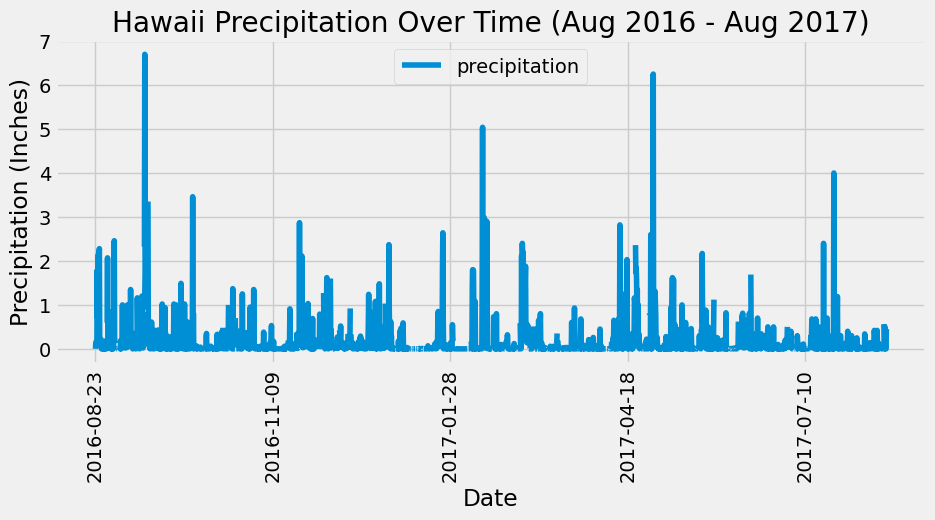

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(y='precipitation', figsize=(10, 4), rot=90)
plt.title('Hawaii Precipitation Over Time (Aug 2016 - Aug 2017)')
plt.legend(["precipitation"],loc='upper center')
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
plt.grid(True)

# Display the plot
plt.savefig('images/ Hawaii Precipitation Bar Chart')
plt.show()

In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [20]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(station.id).count()
station_count

9

In [21]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [measurement.station,
       func.count(measurement.station)]

active_stations = session.query(*sel).\
                    group_by(measurement.station)\
                    .order_by(func.count(measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(measurement.tobs),
       func.max(measurement.tobs),
       func.avg(measurement.tobs)]

most_active_station = session.query(*sel).filter(measurement.station=='USC00519281').all()

most_active_station

[(54.0, 85.0, 71.66378066378067)]

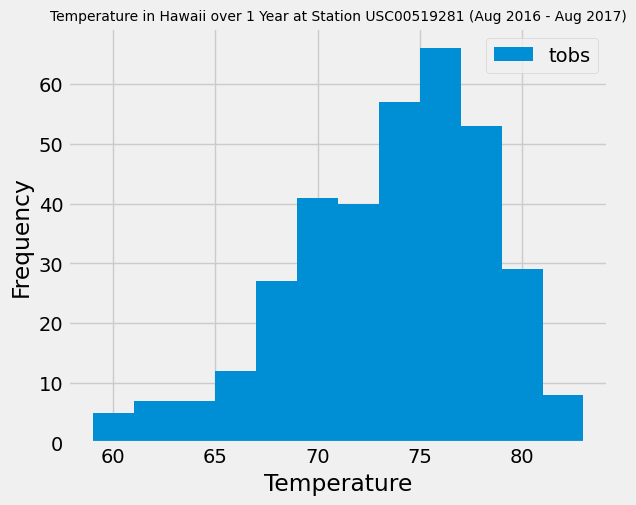

In [33]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_query = session.query(measurement.tobs).\
                filter(measurement.station=='USC00519281').\
                filter(measurement.date>='2016-08-23').all()

#Create plot
active_station_overtime=pd.DataFrame(most_active_station_query,columns=['tobs'])
active_station_overtime.plot.hist(bins=12, alpha=1)
plt.tight_layout()
plt.legend(["tobs"],loc='upper right')
plt.grid(True, alpha=1)
plt.title("Temperature in Hawaii over 1 Year at Station USC00519281 (Aug 2016 - Aug 2017)", size=10)
plt.xlabel("Temperature")
plt.ylabel("Frequency")

plt.savefig('images/ Station USC00519281 Histogram')
plt.show()

# Close Session

In [34]:
# Close Session
session.close()